# SHO Fitting Data

## Import Packages

In [38]:
import sys
sys.path.append('../../')

In [39]:
%load_ext autoreload
import gdown
import time
import h5py
import pyUSID as usid
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch


from src.m3_learning.be.util import print_be_tree, SHO_Fitter
from src.m3_learning.nn.random import random_seed
from src.m3_learning.viz.style import style
from src.m3_learning.be.processing import convert_amp_phase
from src.m3_learning.viz.layout import layout_fig
from src.m3_learning.util.h5_util import make_dataset, make_group
from scipy.signal import resample
from scipy import fftpack



style("default")
random_seed(seed=42)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
default set for seaborn
default set for matplotlib
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loading data for SHO fitting


In [40]:
path = r"C:/Users/jca92/Documents/codes/m3_learning/m3_learning/papers/2023_Rapid_Fitting/data/"

In [41]:
# TODO: place this file on Zenodo before publication
# downloads the original experiment file

# TODO make this so that is creates the folder and checks that it is formatted correctly as a folder - main packages
gdown.download(
    "https://drive.google.com/uc?export=download&id=1Q2Qo_1VGlCsVOTjQpZlE5tjoIV1etVe2",
    path + "data_file.h5",
    quiet=False,
    resume=True,
)

Downloading...
Resume: C:/Users/jca92/Documents/codes/m3_learning/m3_learning/papers/2023_Rapid_Fitting/data\data_file.h5
From: https://drive.google.com/uc?export=download&id=1Q2Qo_1VGlCsVOTjQpZlE5tjoIV1etVe2
To: C:\Users\jca92\Documents\codes\m3_learning\m3_learning\papers\2023_Rapid_Fitting\data\data_file.h5
0.00B [00:00, ?B/s]


'C:/Users/jca92/Documents/codes/m3_learning/m3_learning/papers/2023_Rapid_Fitting/data/data_file.h5'

Prints the Tree to show the Data Structure

In [42]:
print_be_tree(path + "data_file.h5")

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Fit
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ completed_fit_positions
      ├ completed_guess_positions
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS

## SHO Fitting
**Note**: this code takes around 15 minutes to execute

In [21]:
SHO_Fitter(path + "data_file.h5")

C:\Users\jca92\AppData\Roaming\Python\Python310\site-packages\sidpy\sid\translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '


File is already Pycroscopy ready.
Working on:
C:/Users/jca92/Documents/codes/m3_learning/m3_learning/papers/2023_Rapid_Fitting/data/data_file.h5
['Y', 'X'] [60, 60]


SHO Fits will be written to:
C:/Users/jca92/Documents/codes/m3_learning/m3_learning/papers/2023_Rapid_Fitting/data\data_file.h5


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]
Returned previously computed results at /Raw_Data-SHO_Fit_000

Note: SHO_Fit has already been performe

### Extract Data

In [44]:
# Opens the data file
h5_f = h5py.File(path + "data_file.h5", "r+")

# number of samples per SHO fit
num_bins = h5_f["Measurement_000"].attrs["num_bins"]

# number of pixels in the image
num_pix = h5_f["Measurement_000"].attrs["num_pix"]

# number of pixels in x and y dimensions
num_pix_1d = int(np.sqrt(num_pix))

# number of DC voltage steps
voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# sampling rate
sampling_rate = h5_f["Measurement_000"].attrs["IO_rate_[Hz]"]

# BE bandwidth
be_bandwidth = h5_f["Measurement_000"].attrs["BE_band_width_[Hz]"]

# BE center frequency
be_center_frequency = h5_f["Measurement_000"].attrs["BE_center_frequency_[Hz]"]

# Frequency Vector in Hz
frequency_bin = h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"][:]

# Resampled frequency vector
wvec_freq = resample(frequency_bin, 80)

# extracting the excitation waveform
be_waveform = h5_f["Measurement_000"]["Channel_000"]["Excitation_Waveform"]

# extracting spectroscopic values
spectroscopic_values = h5_f["Measurement_000"]["Channel_000"]["Spectroscopic_Values"]

# get raw data (real and imaginary combined)
raw_data = h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]

### Saves the Data

In [23]:
#creates the necessary structure in the H5_file
make_group(h5_f["Measurement_000"]["Channel_000"], 'complex')
make_group(h5_f["Measurement_000"]["Channel_000"], 'magn_spec')

could not add group - it might already exist


In [31]:
h5_f["Measurement_000"]["Channel_000"]['complex']['real'][:] = np.real(h5_f["Measurement_000"]["Channel_000"]["Raw_Data"])
h5_f["Measurement_000"]["Channel_000"]['complex']['imag'][:] = np.imag(h5_f["Measurement_000"]["Channel_000"]["Raw_Data"])

### Visualize Raw Data

In [32]:
h5_f["Measurement_000"]["Channel_000"]['magn_spec']['amp'], h5_f["Measurement_000"]["Channel_000"]['magn_spec']['phase'] = convert_amp_phase(raw_data)

1082 114
Number of time steps: 4096.0


C:\Users\jca92\.conda\envs\rapid_fitting\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


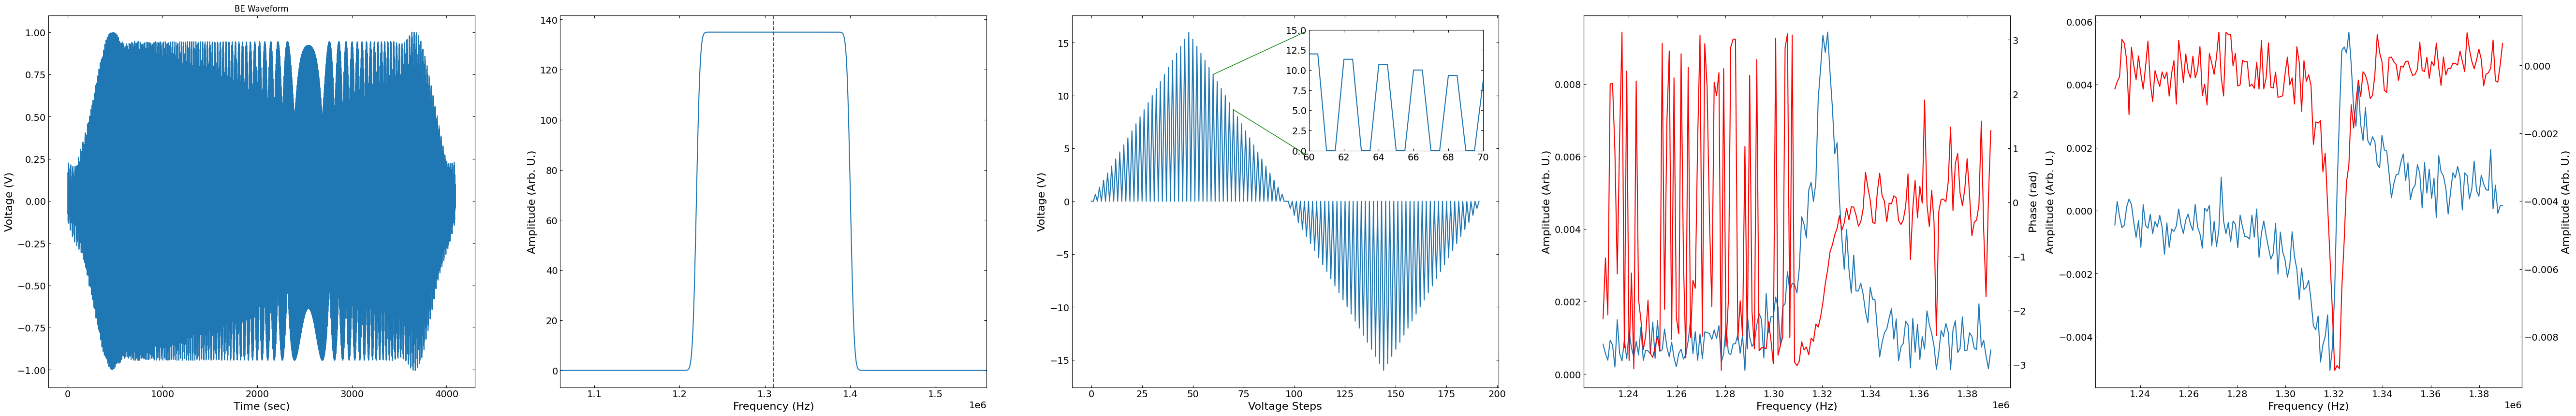

In [45]:
# Selects a random point and timestep to plot
pixel = np.random.randint(0,h5_f["Measurement_000"]["Channel_000"]['magn_spec']['amp'][:].shape[0])
timestep = np.random.randint(h5_f["Measurement_000"]["Channel_000"]['magn_spec']['amp'][:].shape[0]/num_bins)

pixel = 1082 
timestep = 114

print(pixel, timestep)
fig, ax = layout_fig(5, 5, figsize=(6 * 11, 10))

be_timesteps = len(be_waveform) / 4
print("Number of time steps: " + str(be_timesteps))
ax[0].plot(be_waveform[: int(be_timesteps)])
ax[0].set(xlabel="Time (sec)", ylabel="Voltage (V)")
ax[0].set_title("BE Waveform")

resonance_graph = np.fft.fft(be_waveform[: int(be_timesteps)])
fftfreq = fftpack.fftfreq(int(be_timesteps)) * sampling_rate
ax[1].plot(
    fftfreq[: int(be_timesteps) // 2], np.abs(resonance_graph[: int(be_timesteps) // 2])
)
ax[1].axvline(
    x=be_center_frequency,
    ymax=np.max(resonance_graph[: int(be_timesteps) // 2]),
    linestyle="--",
    color="r",
)
ax[1].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax[1].set_xlim(
    be_center_frequency - be_bandwidth - be_bandwidth * 0.25,
    be_center_frequency + be_bandwidth + be_bandwidth * 0.25,
)

hysteresis_waveform = (
    spectroscopic_values[1, ::165][192:] * spectroscopic_values[2, ::165][192:]
)
x_start = 120
x_end = 140

ax[2].plot(hysteresis_waveform)
ax_new = fig.add_axes([0.52, 0.6, 0.3/5.5, 0.25])
ax_new.plot(np.repeat(hysteresis_waveform, 2))
ax_new.set_xlim(x_start, x_end)
ax_new.set_ylim(0, 15)
ax_new.set_xticks(np.linspace(x_start, x_end, 6))
ax_new.set_xticklabels([60, 62, 64, 66, 68, 70])
fig.add_artist(
    ConnectionPatch(
        xyA=(x_start // 2, hysteresis_waveform[x_start // 2]),
        coordsA=ax[2].transData,
        xyB=(105, 16),
        coordsB=ax[2].transData,
        color="green",
    )
)
fig.add_artist(
    ConnectionPatch(
        xyA=(x_end // 2, hysteresis_waveform[x_end // 2]),
        coordsA=ax[2].transData,
        xyB=(105, 4.5),
        coordsB=ax[2].transData,
        color="green",
    )
)
ax[2].set_xlabel("Voltage Steps")
ax[2].set_ylabel("Voltage (V)")

ax[3].plot(
    frequency_bin,
    h5_f["Measurement_000"]["Channel_000"]['magn_spec']['amp'][:].reshape(num_pix, -1, num_bins)[pixel, timestep],
)
ax[3].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax2 = ax[3].twinx()
ax2.plot(
    frequency_bin,
    h5_f["Measurement_000"]["Channel_000"]['magn_spec']['phase'][:].reshape(num_pix, -1, num_bins)[pixel, timestep],
    "r",
)
ax2.set(xlabel="Frequency (Hz)", ylabel="Phase (rad)");

ax[4].plot(frequency_bin, h5_f["Measurement_000"]["Channel_000"]['complex']['real'][pixel].reshape(-1, num_bins)[timestep], label="Real")
ax[4].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax3 = ax[4].twinx()
ax3.plot(
    frequency_bin, h5_f["Measurement_000"]["Channel_000"]['complex']['imag'][pixel].reshape(-1, num_bins)[timestep],'r', label="Imaginary")
ax3.set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)");

### Visualize the SHO Fit Results

In [35]:
# create a list for parameters
fit_results_list = []
for sublist in np.array(
    h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"]
):
    for item in sublist:
        for i in item:
            fit_results_list.append(i)

# flatten parameters list into numpy array
fit_results_list = np.array(fit_results_list).reshape(num_pix, voltage_steps, 5)

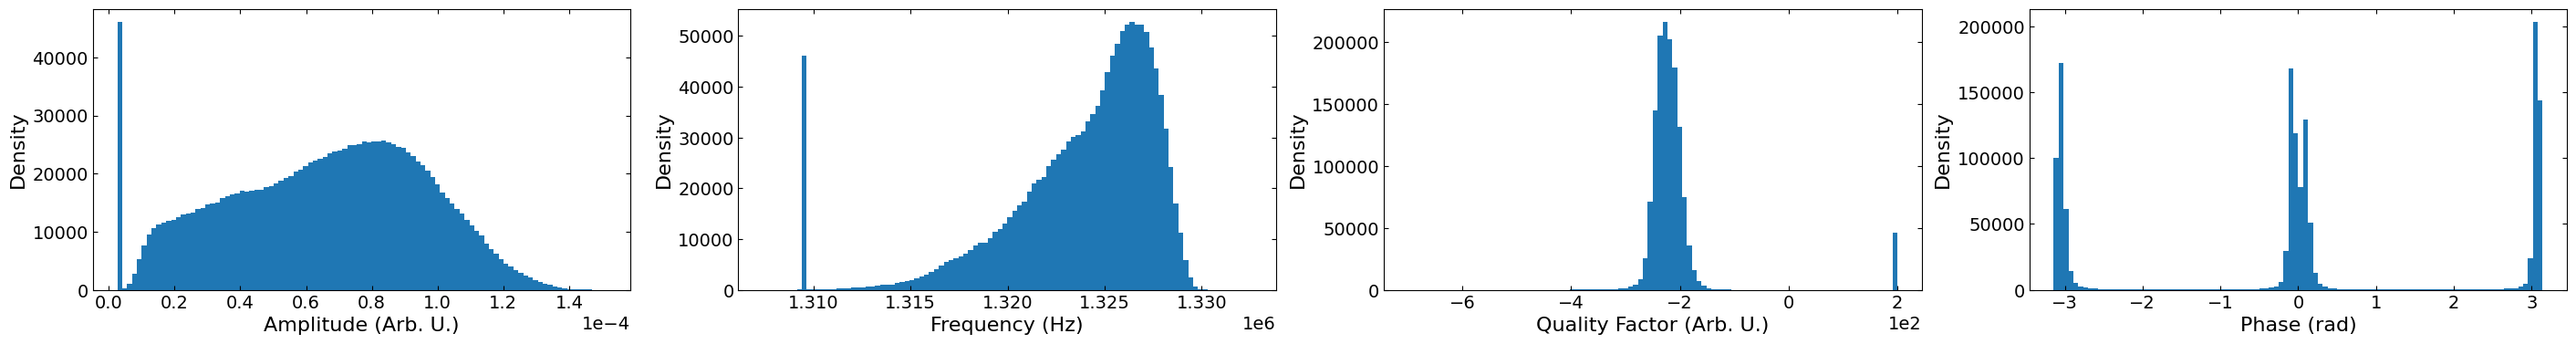

In [36]:
# check distrubutions of each parameter before and after scaling
fig, axs = layout_fig(4, 4, figsize=(35, 4))

units = [
    "Amplitude (Arb. U.)",
    "Frequency (Hz)",
    "Quality Factor (Arb. U.)",
    "Phase (rad)",
]

for i in range(4):
    axs[i].hist(fit_results_list[:, :, i].flatten(), 100)

i = 0
for i, ax in enumerate(axs.flat):
    ax.set(xlabel=units[i], ylabel="Density")
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

In [37]:
# Closes the h5_file
h5_f.close()